## Determine Data Splits

We use batch 11 data to demonstrate proof of concept that we can identify features that distinguish resistant from sensitive clones.

In this notebook, I create a single dataset, using the following procedure:

1. Load batch 11 normalized (level 4a) data
2. Split the five wildtype and and five sensitive clones into training/testing sets
3. Keep the wildtype parental and clone A/E held out
4. Perform feature selection using the training data only
5. Also load the batch 3 data and add to the analytical set as an inference set

In [3]:
import sys
import pathlib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from pycytominer import normalize, feature_select
from pycytominer.cyto_utils import infer_cp_features, write_gct

sys.path.insert(0, "../2.describe-data/scripts")
from processing_utils import load_data

In [4]:
np.random.seed(1233)

In [11]:
data_dir = pathlib.Path("../0.generate-profiles/profiles")
cell_count_dir = pathlib.Path("../0.generate-profiles/cell_counts/")

output_dir = pathlib.Path("data")

profile_suffix = "normalized.csv.gz"

feature_select_opts = [
    "variance_threshold",
    "correlation_threshold",
    "drop_na_columns",
    "blocklist",
    "drop_outliers",
]

corr_threshold = 0.90
na_cutoff = 0

test_set_size = 0.15

In [12]:
datasets = {
    "bortezomib": {
        "2021_03_03_Batch12": ["219907"],
        "2021_03_03_Batch13": ["219973"],
        "2021_03_03_Batch14": ["219901"],
        "2021_03_03_Batch15": ["219956"],
        "2021_03_05_Batch16": ["220039"]
    }
}

validation_plates = {
    "bortezomib": "219901"
}

In [13]:
clones = [
    "BZ001",
    "BZ002",
    "BZ003",
    "BZ004",
    "BZ005",
    "WT clone 01",
    "WT clone 02",
    "WT clone 03",
    "WT clone 04",
    "WT clone 05"
]

In [14]:
# Load and harmonize data for the given plates
full_df = []
for dataset in datasets:
    dataset_df = []
    validation_plate = validation_plates[dataset]
    for batch in datasets[dataset]:
        plates = datasets[dataset][batch]

        # Load and harmonize data for the given plates
        df = load_data(
            batch=batch,
            plates=plates,
            profile_dir=data_dir,
            suffix=profile_suffix,
            combine_dfs=True,
            harmonize_cols=True,
            add_cell_count=True,
            cell_count_dir=cell_count_dir
        )

        # Add important metadata features
        df = df.assign(
            Metadata_dataset=dataset,
            Metadata_batch=batch,
            Metadata_clone_type="resistant",
            Metadata_clone_type_indicator=1,
            Metadata_model_split="training"
        )

        df.loc[df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type"] = "sensitive"
        df.loc[df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type_indicator"] = 0
        dataset_df.append(df)

    # Merge plates of the same dataset together
    dataset_df = pd.concat(dataset_df, axis="rows", sort=False).reset_index(drop=True)
    
    # Generate a unique sample ID
    # (This will be used in singscore calculation)
    dataset_df = dataset_df.assign(
        Metadata_unique_sample_name=[f"profile_{x}_{dataset}" for x in range(0, dataset_df.shape[0])]
    )
    
    dataset_df.loc[
        dataset_df.Metadata_Plate.astype(str) == validation_plate, "Metadata_model_split"
    ] = "validation"
    
    training_df = dataset_df.query("Metadata_model_split == 'training'")

    train_samples, test_samples = train_test_split(
        training_df.Metadata_unique_sample_name,
        random_state=9876,
        test_size=test_set_size,
        stratify=training_df.Metadata_clone_number.astype(str)
    )
    
    dataset_df.loc[
        dataset_df.Metadata_unique_sample_name.isin(test_samples), "Metadata_model_split"
    ] = "test"
    
    full_df.append(dataset_df)

full_df = pd.concat(full_df, axis="rows", sort=False).reset_index(drop=True)

In [15]:
pd.crosstab(full_df.Metadata_dataset, full_df.Metadata_model_split)

Metadata_model_split,test,training,validation
Metadata_dataset,,,
bortezomib,36,204,60


In [16]:
pd.crosstab(full_df.Metadata_clone_number, full_df.Metadata_model_split)

Metadata_model_split,test,training,validation
Metadata_clone_number,,,
BZ001,2,14,4
BZ002,2,14,4
BZ003,3,13,4
BZ004,3,13,4
BZ005,2,14,4
CloneA,2,14,4
CloneE,3,13,4
WT clone 01,3,13,4
WT clone 02,2,14,4


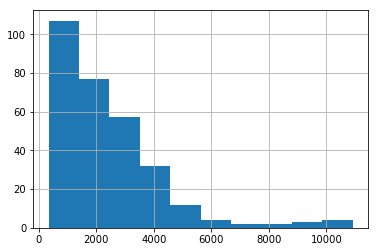

In [17]:
# We see a very large difference in cell count across profiles
# Remember that profiles were generated from averaging feature values for all single cells
full_df.Metadata_cell_count.hist()

In [18]:
# Reorder features
common_metadata = infer_cp_features(full_df, metadata=True)
morph_features = infer_cp_features(full_df)

full_df = full_df.reindex(common_metadata + morph_features, axis="columns")

print(full_df.shape)
full_df.head()

(300, 3546)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,...,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
0,219907,B02,2021_03_03_Batch12,6139,2.5x10^3 cells/well,1,WT_parental,20210205,219814,48 hr,...,-0.643064,-0.634237,-0.655460,-0.667322,-0.654629,-0.697768,-0.632006,-0.629724,-0.634584,-0.632946
1,219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,2,CloneA,20210205,219814,48 hr,...,-0.830887,-0.834485,-0.830467,-0.817834,-0.830908,-0.823437,-0.834719,-0.833202,-0.832762,-0.829608
2,219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,3,CloneE,20210205,219814,48 hr,...,-0.981326,-0.975970,-0.972823,-0.961743,-0.972143,-0.961802,-0.980233,-0.979095,-0.983961,-0.979349
3,219907,B05,2021_03_03_Batch12,5894,2.5x10^3 cells/well,4,WT clone 01,20210205,219814,48 hr,...,-1.086254,-1.082674,-1.068989,-1.066328,-1.057908,-1.061034,-1.090275,-1.086372,-1.088633,-1.085320
4,219907,B06,2021_03_03_Batch12,1277,2.5x10^3 cells/well,5,WT clone 02,20210205,219814,48 hr,...,1.942116,1.911892,1.981961,1.951399,2.035387,2.032162,1.920166,1.959233,1.967471,1.915364


In [32]:
selected_features = []
for dataset in datasets:
        
    # Apply feature selection
    feature_select_df = feature_select(
        full_df.query("Metadata_dataset == @dataset").query("Metadata_model_split == 'training'"),
        operation=feature_select_opts,
        na_cutoff=na_cutoff,
    )

    dataset_features = infer_cp_features(feature_select_df)

    selected_features.append(
        pd.DataFrame(dataset_features, columns=["features"])
        .assign(dataset=dataset)
    )
    
# Output results of feature selection
all_selected_features = pd.concat(selected_features).reset_index(drop=True)

output_file = pathlib.Path(f"{output_dir}/updated_dataset_features_selected.tsv")
all_selected_features.to_csv(output_file, sep="\t", index=False)

all_selected_features.head()

,features,dataset
0,Cells_AreaShape_Compactness,bortezomib
1,Cells_AreaShape_Eccentricity,bortezomib
2,Cells_AreaShape_Extent,bortezomib
3,Cells_AreaShape_FormFactor,bortezomib
4,Cells_AreaShape_MedianRadius,bortezomib


In [33]:
output_file

PosixPath('data/updated_dataset_features_selected.tsv')

In [23]:
# Load inference data (a different hold out)
inference_batch = "2019_06_25_Batch3"
inference_file = pathlib.Path(f"../3.bulk-signatures/data/{inference_batch}_combined_normalized.csv.gz")
inference_df = pd.read_csv(inference_file)

inference_df = inference_df.assign(
    Metadata_dataset="untreated_mystery_clones",
    Metadata_batch=inference_batch,
    Metadata_clone_type="resistant",
    Metadata_clone_type_indicator=1,
    Metadata_model_split="inference"
)

inference_df.loc[inference_df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type"] = "sensitive"
inference_df.loc[inference_df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type_indicator"] = 0
inference_df = inference_df.assign(
    Metadata_unique_sample_name=[f"profile_{x}_inference" for x in range(0, inference_df.shape[0])]
)

inference_df.Metadata_clone_number.value_counts()

WT_parental    6
WT003          3
BZ014          3
BZ007          3
WT010          3
WT015          3
BZ010          3
BZ005          3
BZ004          3
WT001          3
BZ009          3
BZ017          3
WT009          3
WT014          3
WT011          3
WT013          3
BZ018          3
WT005          3
BZ001          3
WT002          3
BZ013          3
WT007          3
WT004          3
BZ002          3
BZ015          3
BZ006          3
BZ012          3
WT006          3
BZ016          3
BZ008          3
WT012          3
WT008          3
BZ011          3
BZ003          3
Name: Metadata_clone_number, dtype: int64

In [26]:
infer_cp_features(inference_df, metadata=True)

['Metadata_Plate',
 'Metadata_Well',
 'Metadata_batch',
 'Metadata_cell_count',
 'Metadata_clone_number',
 'Metadata_plate_map_name',
 'Metadata_treatment',
 'Metadata_unique_sample_name',
 'Metadata_dataset',
 'Metadata_clone_type',
 'Metadata_clone_type_indicator',
 'Metadata_model_split']

In [27]:
infer_cp_features(full_df, metadata=True)

['Metadata_Plate',
 'Metadata_Well',
 'Metadata_batch',
 'Metadata_cell_count',
 'Metadata_cell_density',
 'Metadata_celltype_shorthand_from_plate_graph',
 'Metadata_clone_number',
 'Metadata_date',
 'Metadata_plate_map_name',
 'Metadata_time_to_adhere',
 'Metadata_treatment',
 'Metadata_treatment_shorthand_from_plate_graph',
 'Metadata_treatment_time',
 'Metadata_dataset',
 'Metadata_clone_type',
 'Metadata_clone_type_indicator',
 'Metadata_model_split',
 'Metadata_unique_sample_name']

In [29]:
# Combine profiles into a single dataset and output
bortezomib_df = pd.concat(
    [
        full_df,
        inference_df
    ],
    axis="rows",
    sort=False
).reset_index(drop=True)

output_file = pathlib.Path(f"{output_dir}/bortezomib_signature_analytical_set.tsv.gz")
bortezomib_df.to_csv(output_file, sep="\t", index=False)

In [30]:
print(bortezomib_df.shape)
bortezomib_df.head()

(405, 3546)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,...,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
0,219907,B02,2021_03_03_Batch12,6139,2.5x10^3 cells/well,1.0,WT_parental,20210205.0,219814,48 hr,...,-0.643064,-0.634237,-0.655460,-0.667322,-0.654629,-0.697768,-0.632006,-0.629724,-0.634584,-0.632946
1,219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,2.0,CloneA,20210205.0,219814,48 hr,...,-0.830887,-0.834485,-0.830467,-0.817834,-0.830908,-0.823437,-0.834719,-0.833202,-0.832762,-0.829608
2,219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,3.0,CloneE,20210205.0,219814,48 hr,...,-0.981326,-0.975970,-0.972823,-0.961743,-0.972143,-0.961802,-0.980233,-0.979095,-0.983961,-0.979349
3,219907,B05,2021_03_03_Batch12,5894,2.5x10^3 cells/well,4.0,WT clone 01,20210205.0,219814,48 hr,...,-1.086254,-1.082674,-1.068989,-1.066328,-1.057908,-1.061034,-1.090275,-1.086372,-1.088633,-1.085320
4,219907,B06,2021_03_03_Batch12,1277,2.5x10^3 cells/well,5.0,WT clone 02,20210205.0,219814,48 hr,...,1.942116,1.911892,1.981961,1.951399,2.035387,2.032162,1.920166,1.959233,1.967471,1.915364


In [31]:
assert len(bortezomib_df.Metadata_unique_sample_name.unique()) == bortezomib_df.shape[0]